In [1]:
import pandas as pd
import numpy as np

from keras.layers import LSTM, Dense, Input, Flatten, RepeatVector, Reshape
from keras.models import Model

Using TensorFlow backend.


In [2]:
import matplotlib.pyplot as plt

In [3]:
%matplotlib inline

In [4]:
def windowing(a, window_lenght, step_ahead):
    '''
    a = input array
    window_length = length of each sample of subsequence
    step_ahead = stride of sliding window
    
    return:
    x_sample = subsequence
    y_sample = value of time series n step ahead
    '''
    window_number = (len(a) - step_ahead - window_lenght)
    x_sample = []
    y_sample = []
    for i in range(window_number):
        x_sample.append(a[i:(i + window_lenght), :-1])
        y_sample.append(a[i + window_lenght + step_ahead, -1])

    x_sample = np.asarray(x_sample)
    y_sample = np.asarray(y_sample)

    x_sample = x_sample.reshape((-1, window_lenght, a.shape[1]-1))
    y_sample = y_sample.reshape((-1, 1))

    return x_sample, y_sample

In [5]:
def getLSTM_Autoencoder_model(input_shape=128, input_dim=18, encoded_dim=4):    
    inputs = Input(shape=(input_shape, input_dim))
    encoded = LSTM(encoded_dim*2, activation='tanh')(inputs)
    decoded = Dense(input_shape*input_dim)(encoded)
    decoded = Dense(1)(decoded)
    autoencoder = Model(inputs, decoded)
    encoder = Model(inputs, encoded)
    
    return encoder, autoencoder

In [6]:
import seaborn as sns
input_shape=128
step_ahead=1

In [7]:
def loadTrainingData():
    full_dataFrame=pd.DataFrame()
    
    for i in range(1,7):
        dx = pd.read_csv('data/Test {}/dx/Analisi.csv'.format(i), names=['d0','d1','d2','d3','d4','d5','d6', 'd7', 'd8', 'd9'])
        sx = pd.read_csv('data/Test {}/sx/Analisi.csv'.format(i), names=['s0','s1','s2','s3','s4','s5','s6', 's7', 's8', 's9'])
        length=np.max([len(dx), len(sx)])
        sequence = pd.concat([dx.iloc[:length], sx.iloc[:length]], axis=1)
        target = np.linspace(0,1,length)
        sequence['target']=target
        sequence.head()
        full_dataFrame=full_dataFrame.append(sequence, ignore_index=True)
        del full_dataFrame['d0']
        del full_dataFrame['s0']
        full_dataFrame=full_dataFrame.fillna(0)
    return full_dataFrame

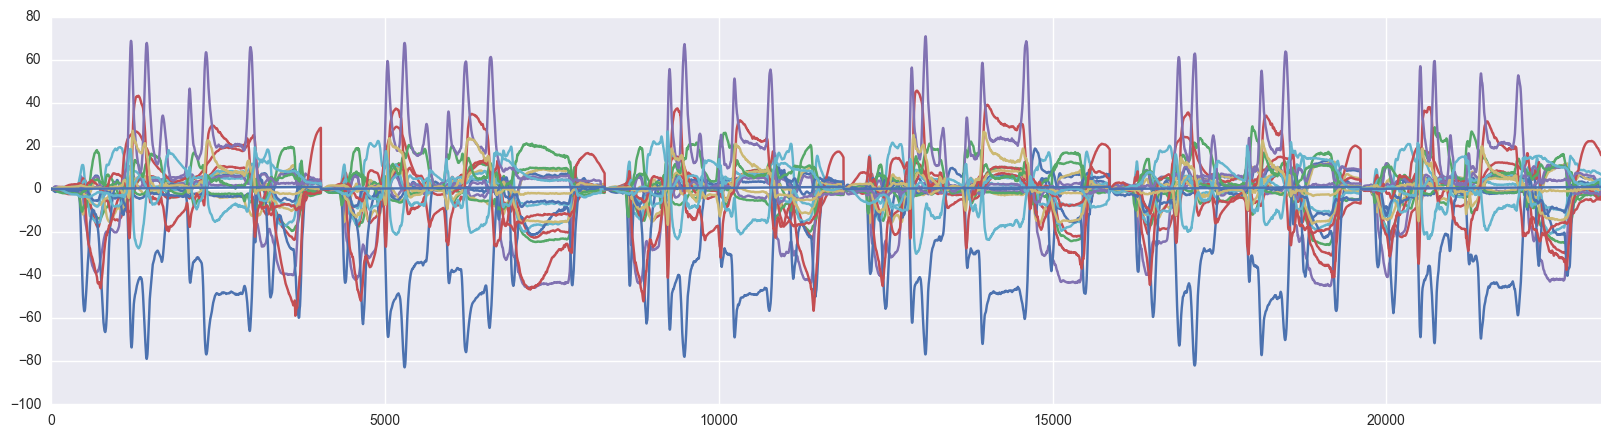

In [8]:
x=loadTrainingData()
x.plot(figsize=(20,5), legend=False)

In [9]:
target = x.loc[:,'target']

In [10]:
#Scaling the input data improves the accuracy of LSTM
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler((-1,1))

In [11]:
x_scaled=scaler.fit_transform(x)

In [12]:
x_,y = windowing(x_scaled, window_lenght=input_shape,step_ahead=step_ahead)

In [13]:
encoder, autoencoder = getLSTM_Autoencoder_model(input_shape=128, input_dim=18, encoded_dim=4)

In [14]:
autoencoder.compile(optimizer='adam', loss='mse')

In [ ]:
history=autoencoder.fit(x_,y,nb_epoch=20,verbose=1, batch_size=128)

In [16]:
x_pred=autoencoder.predict(x_)
x_latent = encoder.predict(x_)
x_real=np.reshape(x_[:,input_shape-1,0], (-1,1))

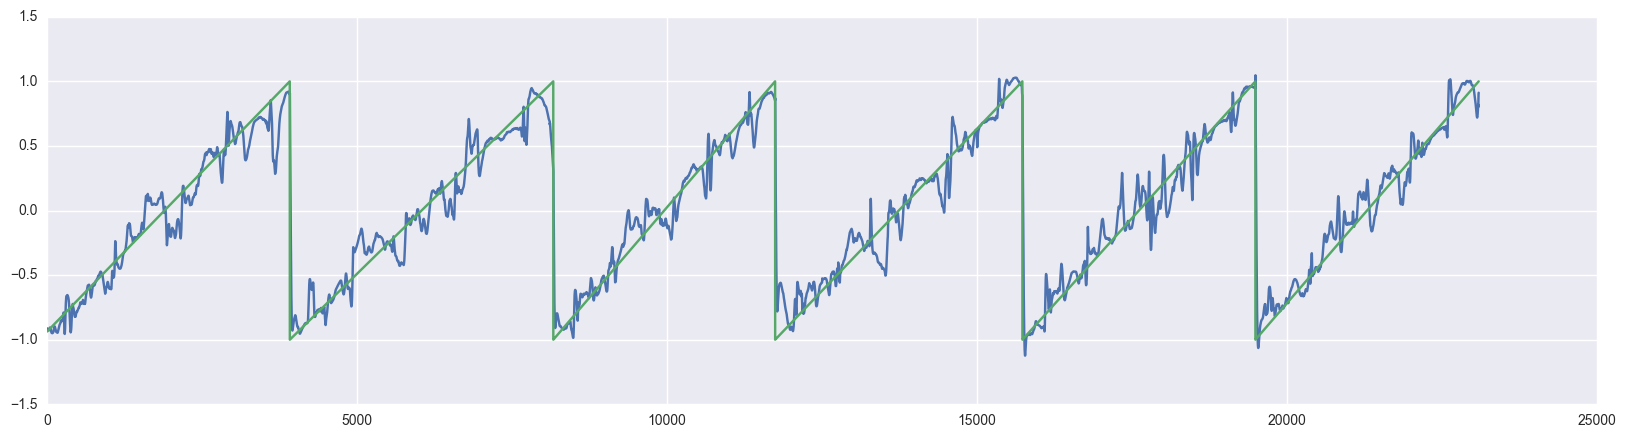

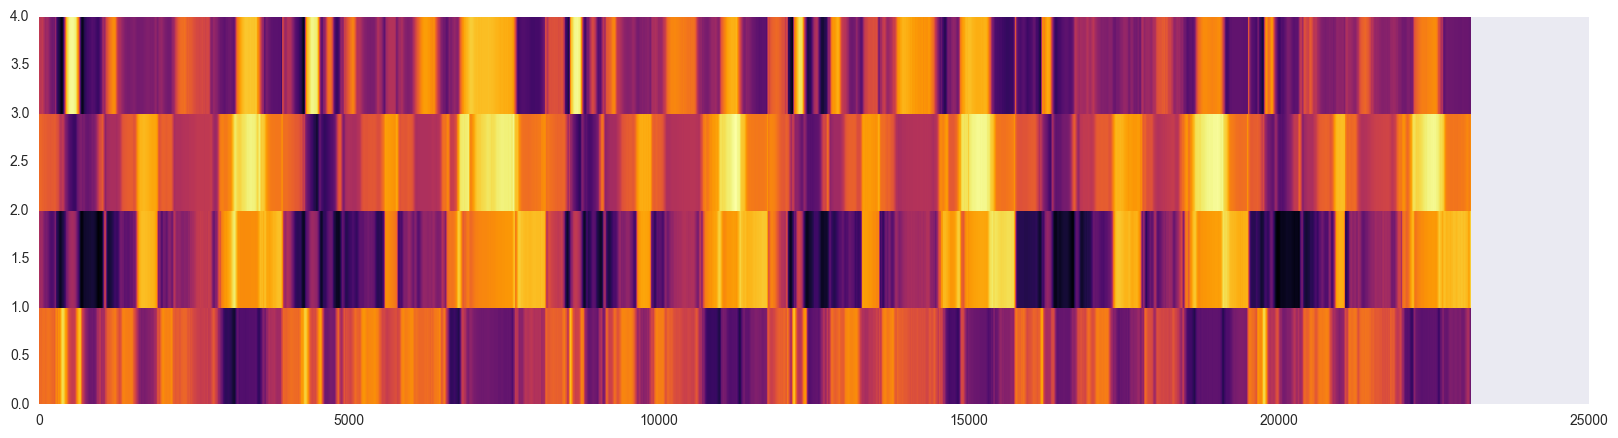

In [17]:
plt.figure(figsize=(20,5))
start=0
size=40000
plt.plot(x_pred[start:start+size,:])
plt.plot(y[start:start+size,:])
plt.figure(figsize=(20,5))
plt.pcolor(x_latent[start:start+size,:4].T, cmap=plt.cm.inferno)

In [18]:
start=0
size=35000
error=(y[start+step_ahead+1:start+step_ahead+size+1]-x_pred[start+step_ahead+1:start+step_ahead+size+1])
sigma3=error.std()*3

In [19]:
graph=np.asarray(x.iloc[:,:-1])

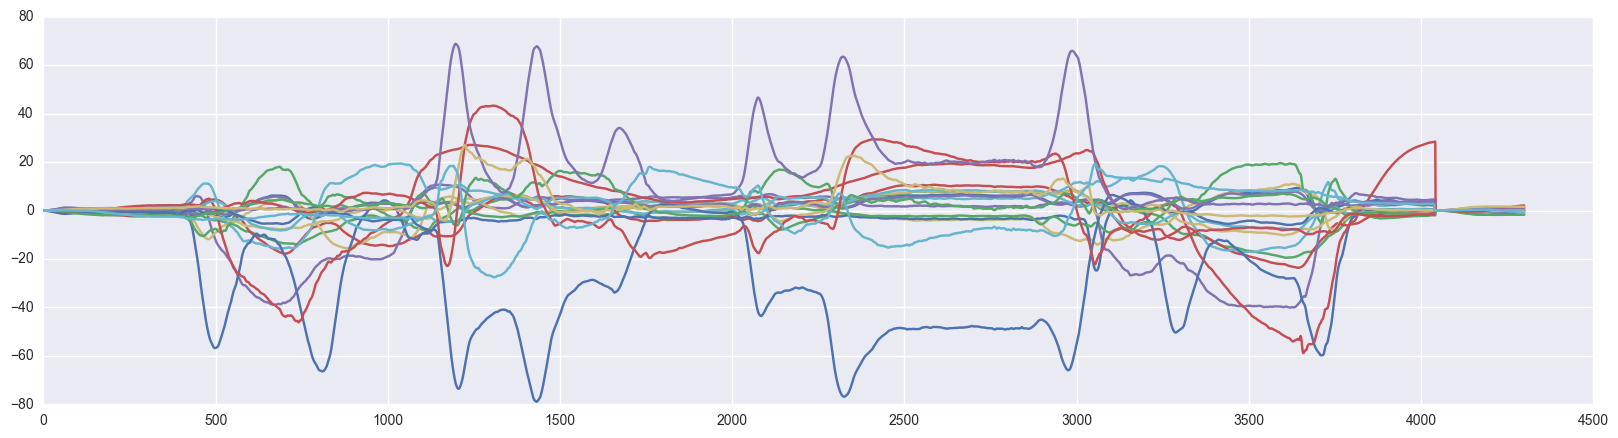

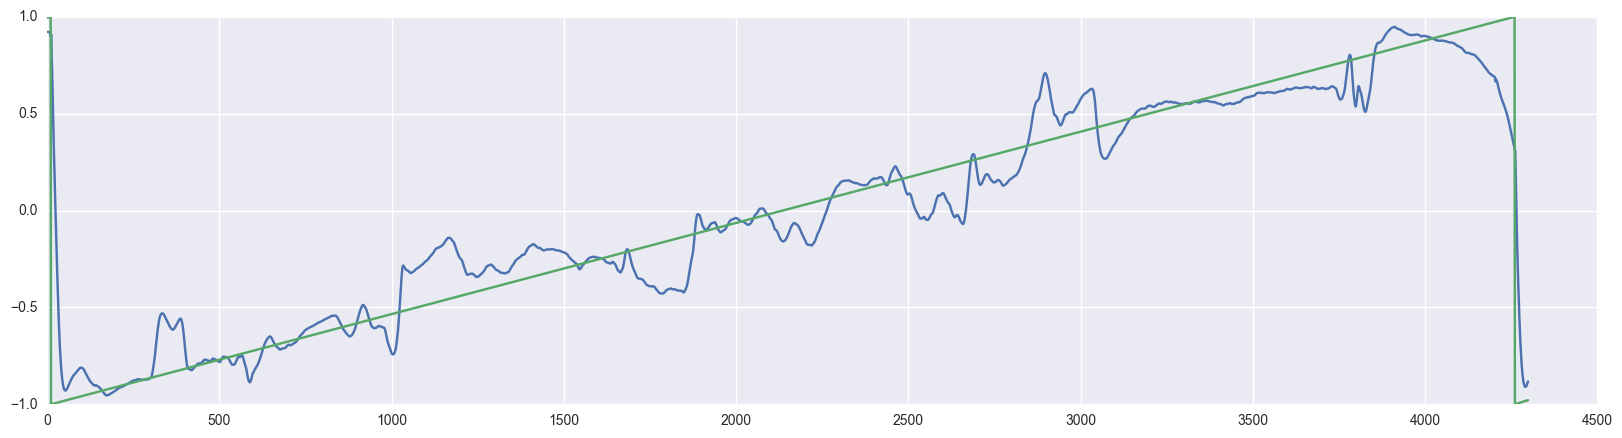

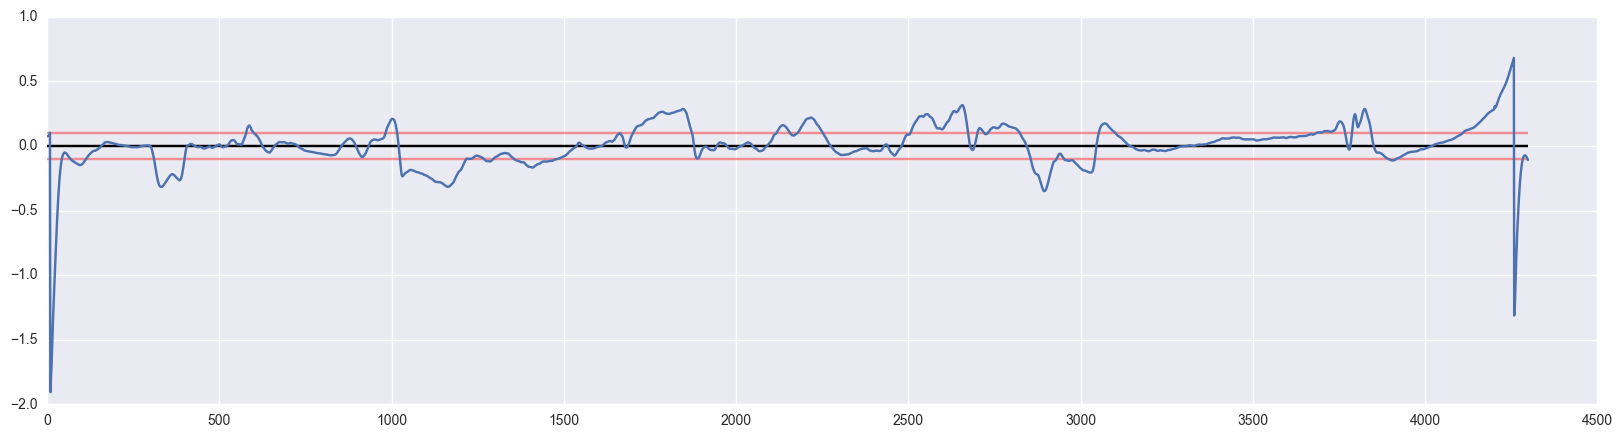

In [20]:
plt.figure(figsize=(20,5))
start=3900
size=4300
plt.plot(graph[:size])
plt.figure(figsize=(20,5))
plt.plot(x_pred[start+step_ahead+1:start+step_ahead+size+1,0])
plt.plot(y[start+step_ahead+1:start+step_ahead+size+1])
plt.figure(figsize=(20,5))
plt.plot(error[start+step_ahead+1:start+step_ahead+size+1])
plt.hlines(0.2/2. ,0, size,alpha=0.4, color='r')
plt.hlines(-0.2/2. ,0, size,alpha=0.4, color='r')
plt.hlines(0 ,0, size)

In [21]:
error_dataFrame=pd.DataFrame()

for i in range(9,11):
    dx = pd.read_csv('data/Test {}_errato/dx/Analisi.csv'.format(i), names=['d0','d1','d2','d3','d4','d5','d6', 'd7', 'd8', 'd9'])
    sx = pd.read_csv('data/Test {}_errato/sx/Analisi.csv'.format(i), names=['s0','s1','s2','s3','s4','s5','s6', 's7', 's8', 's9'])
    length=np.max([len(dx), len(sx)])
    sequence = pd.concat([dx.iloc[:length], sx.iloc[:length]], axis=1)
    target = np.linspace(0,1,length)
    sequence['target']=target
    error_dataFrame=error_dataFrame.append(sequence, ignore_index=True)
    del error_dataFrame['d0']
    del error_dataFrame['s0']
    error_dataFrame=error_dataFrame.fillna(0)

In [22]:
x = x.append(error_dataFrame)
graph=np.asarray(x.iloc[:,:-1])
target = x.loc[:,'target']

In [23]:
x_scaled=scaler.transform(x)

In [24]:
x_,y = windowing(x_scaled, window_lenght=input_shape,step_ahead=step_ahead)

In [25]:
x_pred=autoencoder.predict(x_)
x_latent = encoder.predict(x_)
x_real=np.reshape(x_[:,input_shape-1,0], (-1,1))

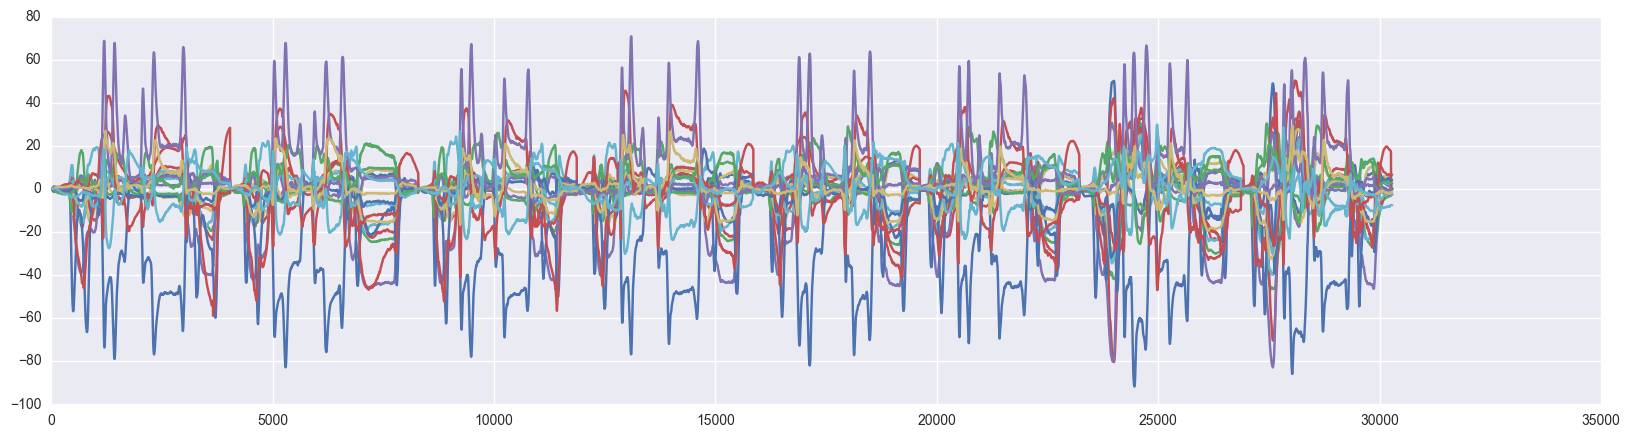

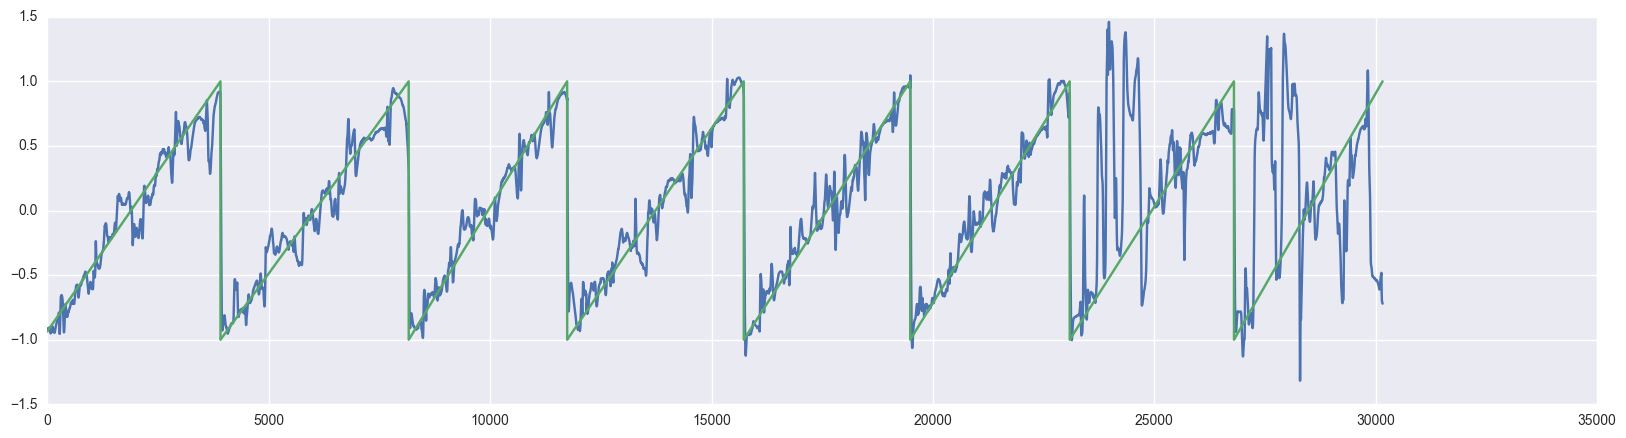

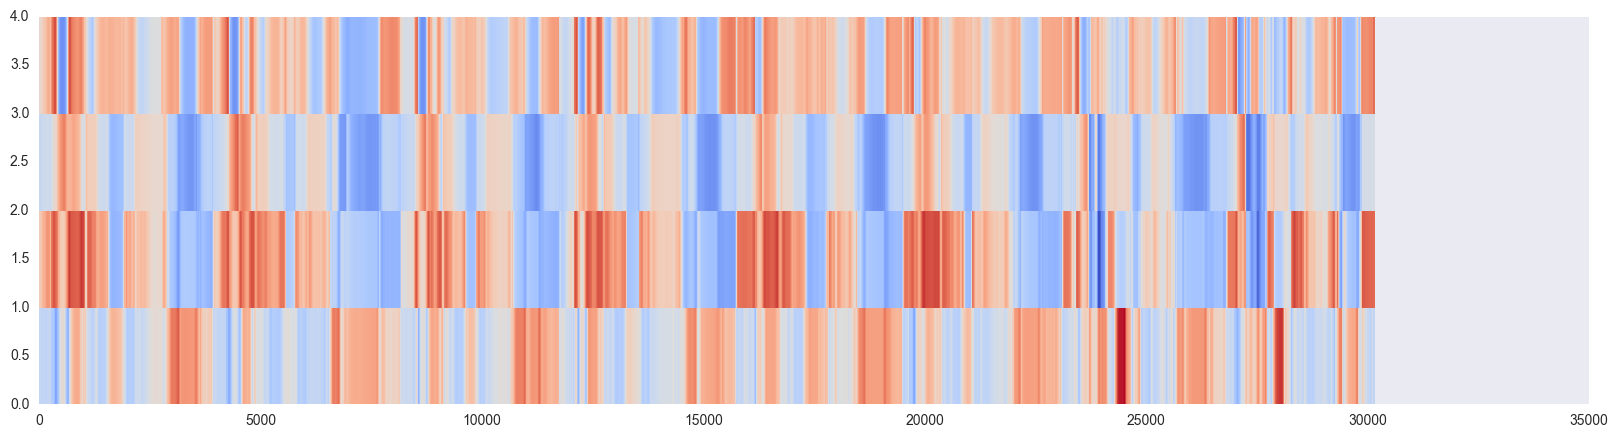

In [26]:
plt.figure(figsize=(20,5))
plt.plot(graph)
plt.figure(figsize=(20,5))
start=0
size=40000
plt.plot(x_pred[start:start+size,:])
plt.plot(y[start:start+size,:])
plt.figure(figsize=(20,5))
plt.pcolor(x_latent[start:start+size,:4].T, cmap=plt.cm.coolwarm_r)

In [27]:
start=0
size=35000
error=(y[start+step_ahead+1:start+step_ahead+size+1]-x_pred[start+step_ahead+1:start+step_ahead+size+1])

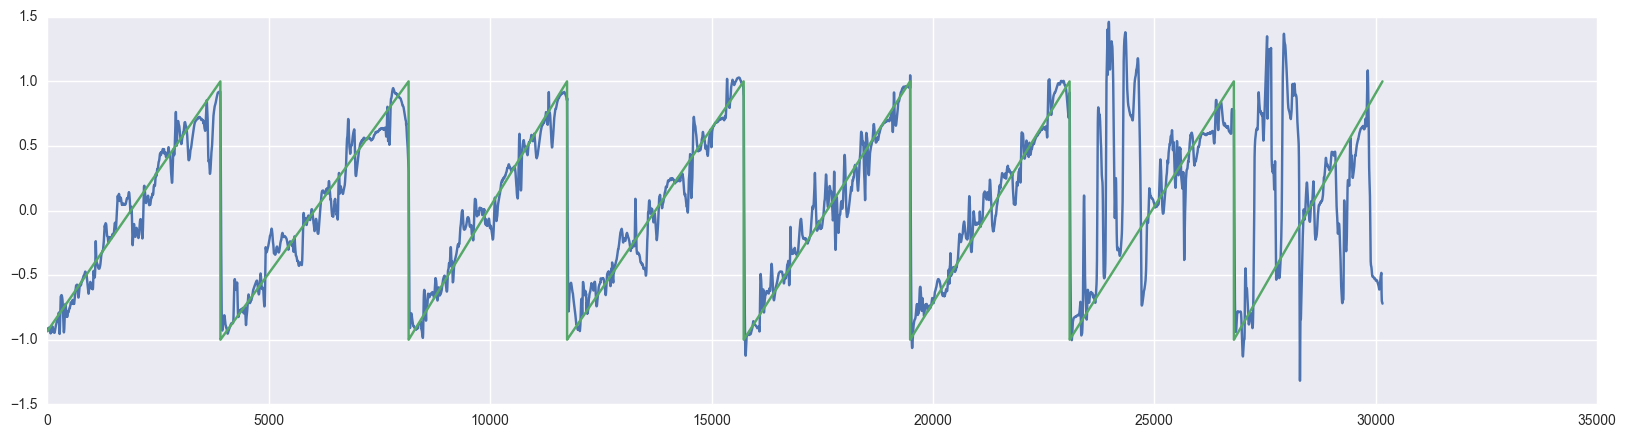

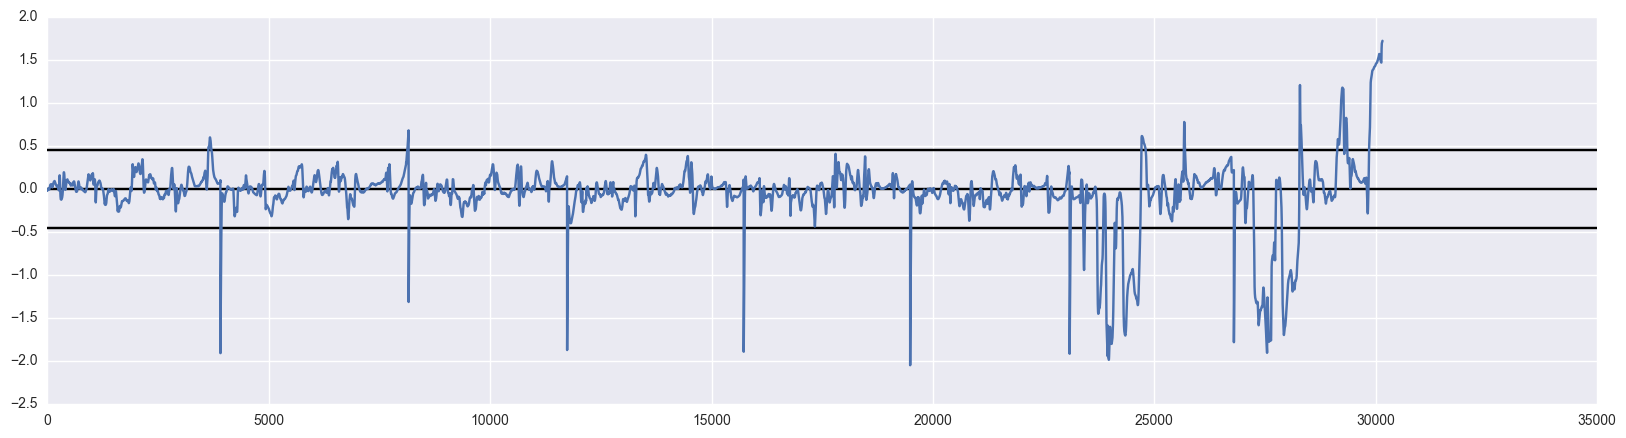

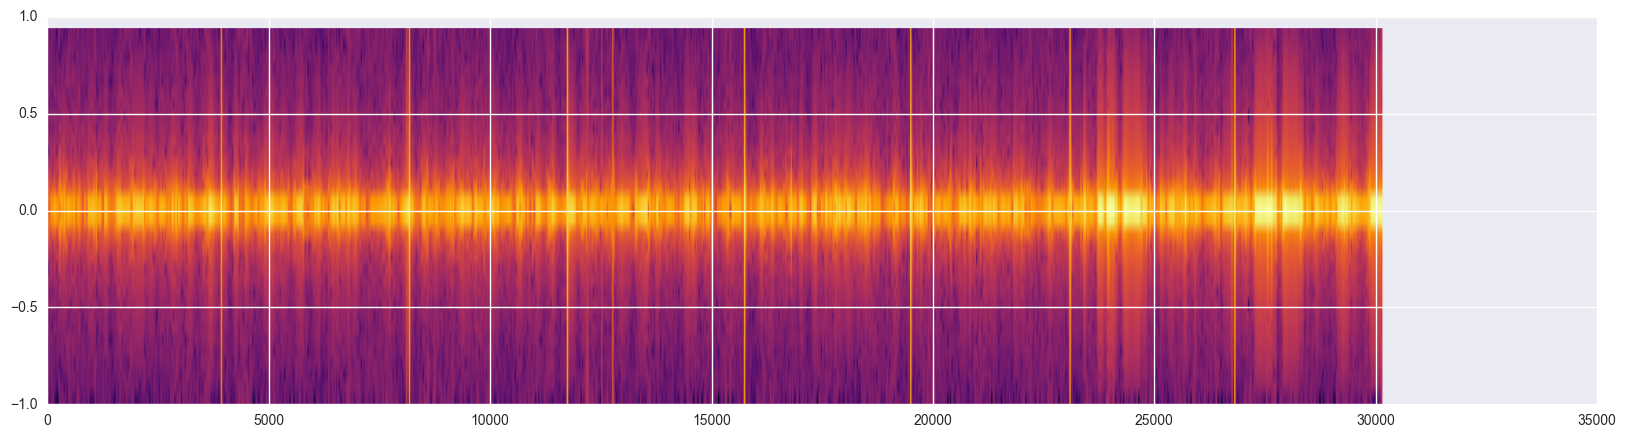

In [28]:
plt.figure(figsize=(20,5))
plt.plot(x_pred[start+step_ahead+1:start+step_ahead+size+1,0])
plt.plot(y[start+step_ahead+1:start+step_ahead+size+1])

plt.figure(figsize=(20,5))
plt.plot(error)
plt.hlines(sigma3 ,0, size)
plt.hlines(-sigma3 ,0, size)
plt.hlines(0 ,0, size)

nfft=32
plt.figure(figsize=(20,5))
values=plt.specgram(error[:,0], 
             NFFT=nfft, 
             noverlap=1, 
             sides='twosided', 
             xextent=(nfft/2.0,
                      len(error)-nfft/2.0),
             cmap='inferno')